# Instalando libs necessárias

In [0]:
!pip install graphviz==0.9
!pip install pydot
!pip install seaborn==0.9.0

!apt-get install graphviz

  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 215kB 2.7MB/s 
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


# Carregando os dados

In [0]:
import pandas as pd

In [0]:
 carros_df = pd.read_csv("https://raw.githubusercontent.com/SrDiegoH/DataScience/master/machine-learning-otimizacao-de-modelos-atraves-de-hiperparametros-e-exploracao-aleatoria/machine-learning-carros-simulacao.csv")
 carros_df = carros_df.drop(columns=["Unnamed: 0"], axis=1)

In [0]:
carros_df.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


# Situação em que as classes estão ordenadas

Simulando situação com o dataframe

In [0]:
dados_ordenados = carros_df.sort_values("vendido", ascending=True)

x_ordenado = dados_ordenados[["preco", "idade_do_modelo","km_por_ano"]]
y_ordenado = dados_ordenados["vendido"]

dados_ordenados.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [0]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

Gerando numero aleatorio utilizando uma seed para ser replicavel

In [0]:
SEED = 301

np.random.seed(SEED)

## Montando o modelo com DummyClassifier

In [0]:
modelo = DummyClassifier()

In [0]:
results = cross_validate(modelo, x_ordenado, y_ordenado, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

print("Acurácia utilizando dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Acurácia utilizando dummy stratified, 10 = [49.79, 53.45]


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


## Montando o modelo com DecisionTreeClassifier

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

In [0]:
modelo = DecisionTreeClassifier(max_depth=2)

In [0]:
results = cross_validate(modelo, x_ordenado, y_ordenado, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

print("Acurácia utilizando cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Acurácia utilizando cross validation, 10 = [73.83, 77.73]


## Agora gerando os dados de forma aleatória

In [0]:
carros_df['modelo'] = carros_df.idade_do_modelo + np.random.randint(-2, 3, size=10000)
carros_df.modelo = carros_df.modelo + abs(carros_df.modelo.min()) + 1
carros_df.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,20
1,40557.96,1,20,12622.05362,23
2,89627.50,0,12,11440.79806,16
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,8


Função simples para exibir os resultados:

In [0]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100

  print(f"Acurácia média {media.round(3)}")
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Montando pipeline com StandardScaler e SVC

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

In [0]:
scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao', scaler), ('estimador', modelo)])

Adicionando pipeline ao GroupKFold e validando



In [0]:
cv = GroupKFold(n_splits = 10)

results = cross_validate(pipeline, x_ordenado, y_ordenado, cv=cv, groups=carros_df.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 76.532
Intervalo [73.70, 79.37]


Agora analisando como o modelo se comporta com novos grupos

In [0]:
cv = GroupKFold(n_splits = 10)

modelo = DecisionTreeClassifier(max_depth=2)

results = cross_validate(modelo, x_ordenado, y_ordenado, cv=cv, groups=carros_df.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 75.779
Intervalo [73.38, 78.18]


Mostrando rede com DecisionTreeClassifier

In [0]:
from sklearn.tree import export_graphviz
import graphviz

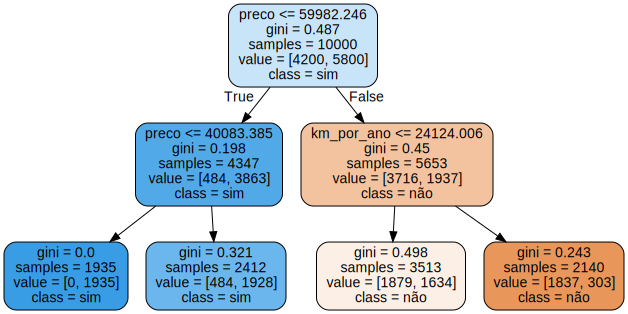

In [0]:
modelo.fit(x_ordenado, y_ordenado)

features = x_ordenado.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

Novamente, analisando como o modelo se comporta com novos grupos (maior profundidade)

In [0]:
cv = GroupKFold(n_splits = 10)

modelo = DecisionTreeClassifier(max_depth=3)

results = cross_validate(modelo, x_ordenado, y_ordenado, cv=cv, groups=carros_df.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 78.674
Intervalo [75.32, 82.03]


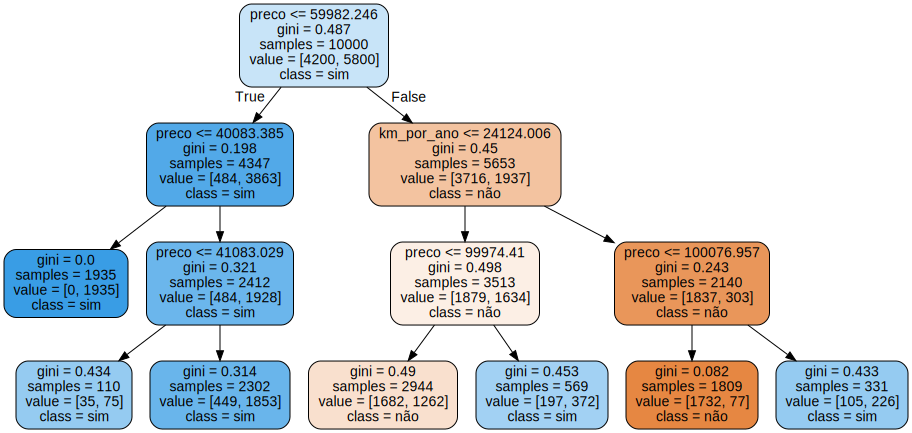

In [0]:
modelo.fit(x_ordenado, y_ordenado)

features = x_ordenado.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

Mais uma vez, analisando como o modelo se comporta com novos grupos (profundidade bem maior)

In [0]:
cv = GroupKFold(n_splits = 10)

modelo = DecisionTreeClassifier(max_depth=10)

results = cross_validate(modelo, x_ordenado, y_ordenado, cv = cv, groups = carros_df.modelo, return_train_score=False)
imprime_resultados(results)

Acurácia média 76.902
Intervalo [74.02, 79.78]


Podemos ver que a acurácia cai em relação a anterior

# Hiper parâmetros com apenas uma dimensão


In [0]:
def roda_arvore_de_decisao(profundidade):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits=10)

  modelo = DecisionTreeClassifier(max_depth=profundidade)

  results = cross_validate(modelo, x_ordenado, y_ordenado, cv=cv, groups=carros_df.modelo, return_train_score=True)

  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  print(f"Árvore -> profundidade = {profundidade}, treino = {train_score.round(3)}, teste = {test_score.round(3)}")

  return [profundidade, train_score, test_score]

In [0]:
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns= ["max_depth","train","test"])

Árvore -> profundidade = 1, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, treino = 75.791, teste = 75.779
Árvore -> profundidade = 3, treino = 78.756, teste = 78.674
Árvore -> profundidade = 4, treino = 78.793, teste = 78.604
Árvore -> profundidade = 5, treino = 78.936, teste = 78.597
Árvore -> profundidade = 6, treino = 79.186, teste = 78.468
Árvore -> profundidade = 7, treino = 79.485, teste = 78.084
Árvore -> profundidade = 8, treino = 79.935, teste = 77.839
Árvore -> profundidade = 9, treino = 80.464, teste = 77.327
Árvore -> profundidade = 10, treino = 81.137, teste = 76.982
Árvore -> profundidade = 11, treino = 82.011, teste = 76.606
Árvore -> profundidade = 12, treino = 82.981, teste = 76.443
Árvore -> profundidade = 13, treino = 84.045, teste = 75.725
Árvore -> profundidade = 14, treino = 85.137, teste = 75.623
Árvore -> profundidade = 15, treino = 86.213, teste = 75.534
Árvore -> profundidade = 16, treino = 87.429, teste = 74.845
Árvore -> profundidade = 17, trei

Plotando profundidades vs treino

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


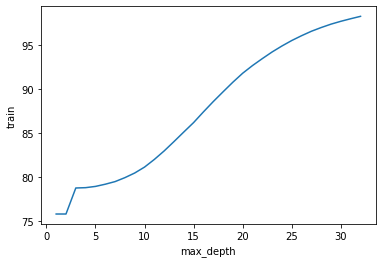

In [0]:
sns.lineplot(x = "max_depth", y = "train", data = resultados)

Plotando profundidades vs test

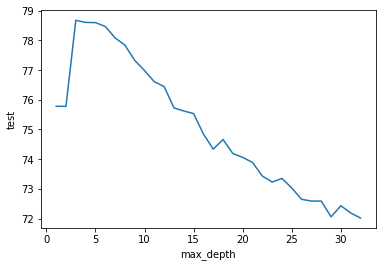

In [0]:
sns.lineplot(x = "max_depth", y = "test", data = resultados)

Como podemos ver, para o treino ficou bom, mas para o teste não... isso ocorre por que ocorreu um overfit (dados viciados para aquela massa)

In [0]:
import matplotlib.pyplot as plt


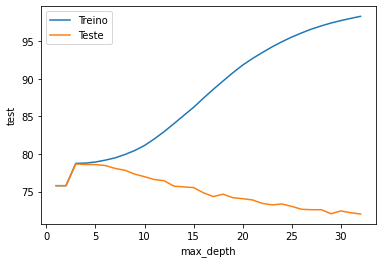

In [0]:
sns.lineplot(x="max_depth", y="train", data=resultados)
sns.lineplot(x="max_depth", y="test", data=resultados)
plt.legend(["Treino", "Teste"])

In [0]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.755605,78.673716
3,4,78.793388,78.604045
4,5,78.935592,78.596576
5,6,79.185673,78.467568
6,7,79.484727,78.083640


# Hiper parâmetros com duas dimensões




In [0]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

  results = cross_validate(modelo, x_ordenado, y_ordenado, cv=cv, groups=carros_df.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  print(f"Árvore -> profundidade = {max_depth}, min_samples_leaf = {min_samples_leaf}, treino = {train_score.round(3)}, teste = {test_score.round(3)}")
  
  return [max_depth, min_samples_leaf, train_score, test_score]

In [0]:
def busca():
  resultados = []

  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)

  resultados = pd.DataFrame(resultados, columns=["max_depth","min_samples_leaf","train","test"])
  
  return resultados

In [0]:
resultados = busca()

Árvore -> profundidade = 1, min_samples_leaf = 32, treino = 75.791, teste = 75.779
Árvore -> profundidade = 1, min_samples_leaf = 64, treino = 75.791, teste = 75.779
Árvore -> profundidade = 1, min_samples_leaf = 128, treino = 75.791, teste = 75.779
Árvore -> profundidade = 1, min_samples_leaf = 256, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 32, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 64, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 128, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 256, treino = 75.791, teste = 75.779
Árvore -> profundidade = 3, min_samples_leaf = 32, treino = 78.753, teste = 78.674
Árvore -> profundidade = 3, min_samples_leaf = 64, treino = 78.753, teste = 78.674
Árvore -> profundidade = 3, min_samples_leaf = 128, treino = 78.753, teste = 78.674
Árvore -> profundidade = 3, min_samples_leaf = 256, treino = 78.753, teste = 78.67

In [0]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,64,78.753381,78.673716
11,3,256,78.753381,78.673716
15,4,256,78.753381,78.673716
14,4,128,78.753381,78.673716
12,4,32,78.753381,78.673716


Correlação entre os dados

In [0]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000,0.000000,0.547410,-0.015495
min_samples_leaf,0.000000,1.000000,-0.405657,0.450476
train,0.547410,-0.405657,1.000000,0.193711
test,-0.015495,0.450476,0.193711,1.000000


Mapa de calor da correlação entre os dados

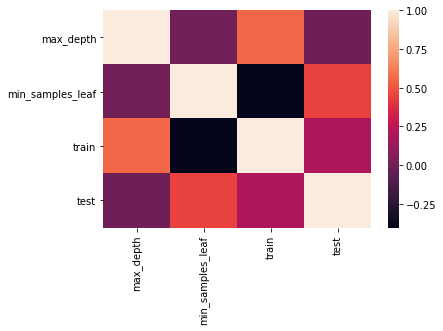

In [0]:
sns.heatmap(corr)

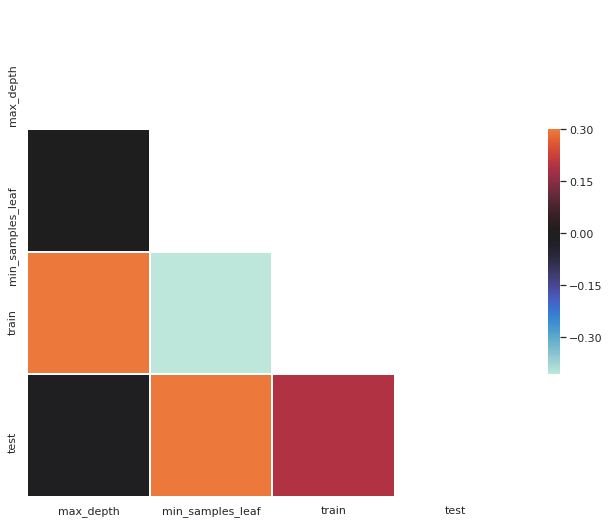

In [0]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Scatter matrix

* https://medium.com/@raghavan99o/scatter-matrix-covariance-and-correlation-explained-14921741ca56

In [0]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feba013ceb8>,
      dtype=object)

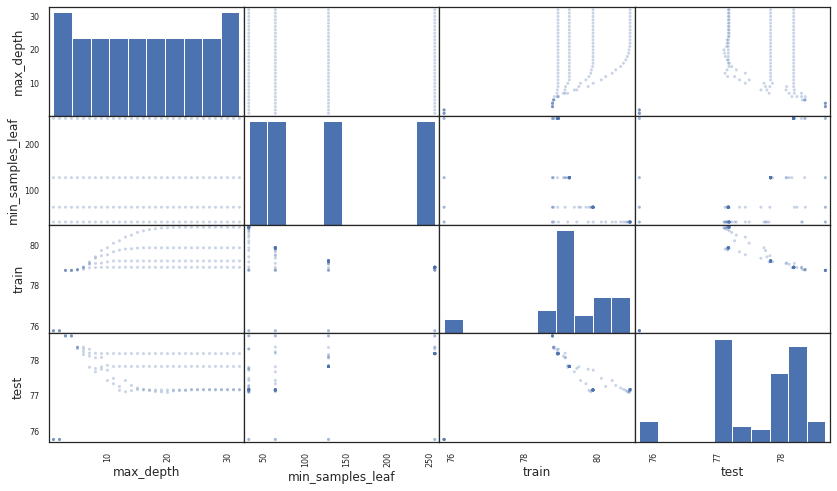

In [0]:
scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3)

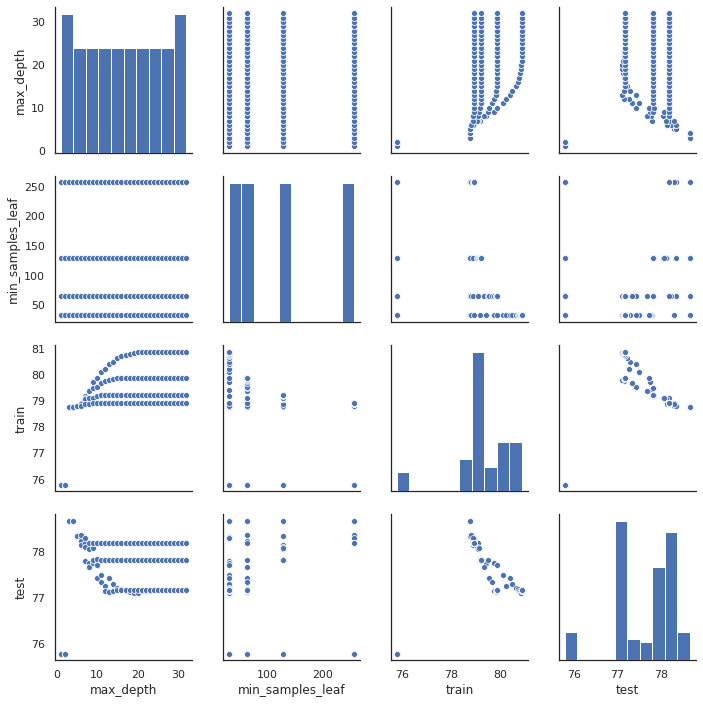

In [0]:
sns.pairplot(resultados)

Alterando min samples leaf

In [0]:
def busca():
  resultados = []

  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  
  resultados = pd.DataFrame(resultados, columns=["max_depth","min_samples_leaf","train","test"])
  return resultados

In [0]:
resultados = busca()

Árvore -> profundidade = 1, min_samples_leaf = 128, treino = 75.791, teste = 75.779
Árvore -> profundidade = 1, min_samples_leaf = 192, treino = 75.791, teste = 75.779
Árvore -> profundidade = 1, min_samples_leaf = 256, treino = 75.791, teste = 75.779
Árvore -> profundidade = 1, min_samples_leaf = 512, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 128, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 192, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 256, treino = 75.791, teste = 75.779
Árvore -> profundidade = 2, min_samples_leaf = 512, treino = 75.791, teste = 75.779
Árvore -> profundidade = 3, min_samples_leaf = 128, treino = 78.753, teste = 78.674
Árvore -> profundidade = 3, min_samples_leaf = 192, treino = 78.753, teste = 78.674
Árvore -> profundidade = 3, min_samples_leaf = 256, treino = 78.753, teste = 78.674
Árvore -> profundidade = 3, min_samples_leaf = 512, treino = 77.528, teste =

In [0]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000,0.000000,0.350717,0.217406
min_samples_leaf,0.000000,1.000000,-0.637327,-0.284651
train,0.350717,-0.637327,1.000000,0.840928
test,0.217406,-0.284651,0.840928,1.000000


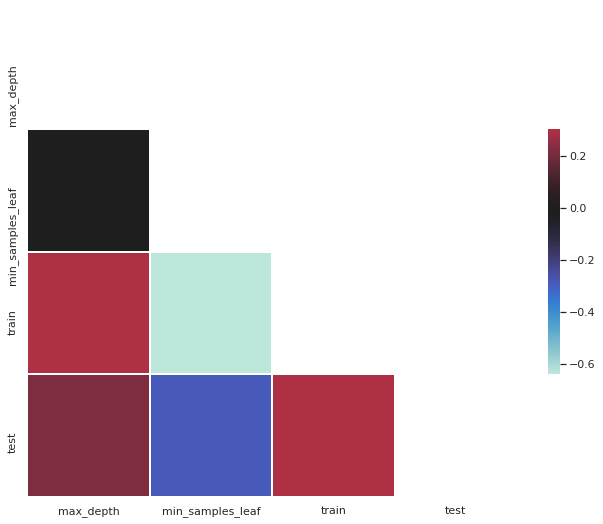

In [0]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
14,4,256,78.753381,78.673716
8,3,128,78.753381,78.673716
13,4,192,78.753381,78.673716
12,4,128,78.753381,78.673716
10,3,256,78.753381,78.673716


# Hiper parâmetros com três imensões

In [0]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)

  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_ordenado, y_ordenado, cv=cv, groups = carros_df.modelo, return_train_score=True)
  
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

In [0]:
def busca():

  resultados = []
  
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","min_samples_split","train","test", "fit_time", "score_time"])
  return resultados


In [0]:
resultados = busca()

In [0]:
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791101,75.779083,0.006287,0.001089
1,1,32,64,75.791101,75.779083,0.005414,0.000990
2,1,32,128,75.791101,75.779083,0.005553,0.001086
3,1,32,256,75.791101,75.779083,0.005402,0.000986
4,1,64,32,75.791101,75.779083,0.005367,0.000981


In [0]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000,0.000000,0.000000,0.542681,0.005924,0.569300,0.123889
min_samples_leaf,0.000000,1.000000,0.000000,-0.351385,0.403161,-0.514343,-0.085887
min_samples_split,0.000000,0.000000,1.000000,-0.101860,0.089904,-0.058238,-0.009532
train,0.542681,-0.351385,-0.101860,1.000000,0.293048,0.900295,0.232658
test,0.005924,0.403161,0.089904,0.293048,1.000000,-0.053400,-0.036828
fit_time,0.569300,-0.514343,-0.058238,0.900295,-0.053400,1.000000,0.397219
score_time,0.123889,-0.085887,-0.009532,0.232658,-0.036828,0.397219,1.000000


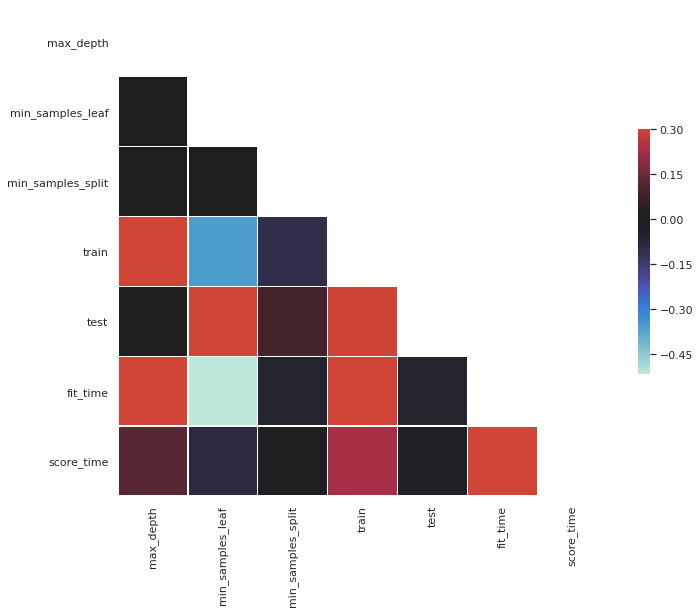

In [0]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
36,3,64,32,78.753381,78.673716,0.010076,0.001004
37,3,64,64,78.753381,78.673716,0.010084,0.000997
49,4,32,64,78.753381,78.673716,0.012411,0.001012
48,4,32,32,78.753381,78.673716,0.013179,0.001135
47,3,256,256,78.753381,78.673716,0.010341,0.001005


# Explorando espaço de hiper parâmetros utilizando GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_ordenado, y_ordenado, groups = carros_df.modelo)

GridSearchCV(cv=GroupKFold(n_splits=10), error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'

In [0]:
resultados = pd.DataFrame(busca.cv_results_)

In [0]:
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010998,0.002113,0.001080,0.000086,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
1,0.010121,0.000150,0.001050,0.000070,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
2,0.010101,0.000130,0.001015,0.000049,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
3,0.010087,0.000058,0.001022,0.000053,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
4,0.010386,0.000472,0.001125,0.000174,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1


In [0]:
print(f"Melhores parametros: {busca.best_params_}")
print(f"Melhor pontuação: {busca.best_score_ * 100}")

melhor = busca.best_estimator_
print(f"Melhor Estimador: {melhor}")

Melhores parametros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
Melhor pontuação: 78.67371606412836
Melhor Estimador: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [0]:
from sklearn.metrics import accuracy_score


In [0]:
predicoes = melhor.predict(x_ordenado)
accuracy = accuracy_score(predicoes, y_ordenado) * 100

print(f"Acuráácia para os dados foi {accuracy.round(3)}")

Acuráácia para os dados foi 78.75


Deve-se evitar essa abordagem pois estará sendo otimista

# Evitando vicios nas estimativa

## Busca com GridSearchCV

Para evitar uma estimativa com vício nos dados, usamos a tecnica nested cross validation. Esta consiste em no caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada.

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
scores = cross_val_score(busca, x_ordenado, y_ordenado, cv=GroupKFold(n_splits=10), groups=carros_df.modelo)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The 'groups' parameter should not be None.

  FitFailedWarning)


O Pandas não suporta nested validation com group k fold, não conseguimos prever o resultado para novos grupos

In [0]:
from sklearn.model_selection import GridSearchCV, KFold

In [0]:
espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_ordenado, y_ordenado)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             par

In [0]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009763,0.000480,0.001193,0.000087,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.781,0.778,0.8,0.7905,0.7855,0.787,0.007752,1
1,0.009217,0.000125,0.001208,0.000115,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.781,0.778,0.8,0.7905,0.7855,0.787,0.007752,1
2,0.009494,0.000264,0.001235,0.000102,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.781,0.778,0.8,0.7905,0.7855,0.787,0.007752,1
3,0.009561,0.000467,0.001235,0.000181,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.781,0.778,0.8,0.7905,0.7855,0.787,0.007752,1
4,0.009160,0.000148,0.001141,0.000046,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.781,0.778,0.8,0.7905,0.7855,0.787,0.007752,1


In [0]:
scores = cross_val_score(busca, x_ordenado, y_ordenado, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.782 , 0.784 , 0.791 , 0.781 , 0.7965])

In [0]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100

  print(f"Acurácia média {media.round(2)}")
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [0]:
imprime_score(scores)

Acurácia média 78.69
Intervalo [77.50, 79.88]


In [0]:
melhor = busca.best_estimator_

print(f"Melhor estimador {melhor}")

Melhor estimador DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


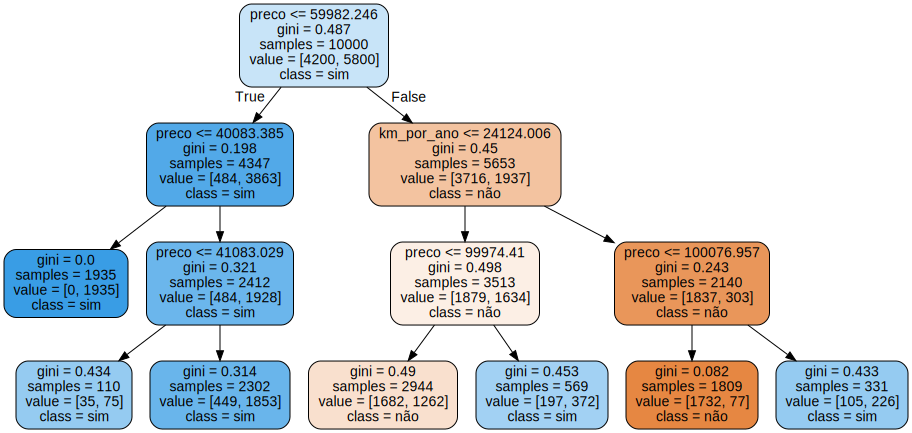

In [0]:
features = x_ordenado.columns

dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não", "sim"],
                          feature_names=features)

graph = graphviz.Source(dot_data)
graph

## Busca aleatória com RandomSearch

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16,
                    cv=KFold(n_splits = 5, shuffle=True),
                    random_state=SEED)

busca.fit(x_ordenado, y_ordenado)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
             

In [0]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012805,0.000495,0.001338,0.000096,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7875,0.778,0.7915,0.7775,0.7885,0.7846,0.005748,16
1,0.009274,0.000147,0.001160,0.000076,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7915,0.778,0.7915,0.7850,0.7885,0.7869,0.005054,1
2,0.009194,0.000090,0.001208,0.000076,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7915,0.778,0.7915,0.7850,0.7885,0.7869,0.005054,1
3,0.019232,0.000230,0.001361,0.000122,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7915,0.778,0.7915,0.7850,0.7885,0.7869,0.005054,1
4,0.019867,0.001399,0.001434,0.000143,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7915,0.778,0.7915,0.7850,0.7885,0.7869,0.005054,1


In [0]:
scores = cross_val_score(busca, x_ordenado, y_ordenado, cv=KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Acurácia média 78.68
Intervalo [77.28, 80.08]


In [0]:
melhor = busca.best_estimator_

print(f"Melhor estimador {melhor}")

Melhor estimador DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=64,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


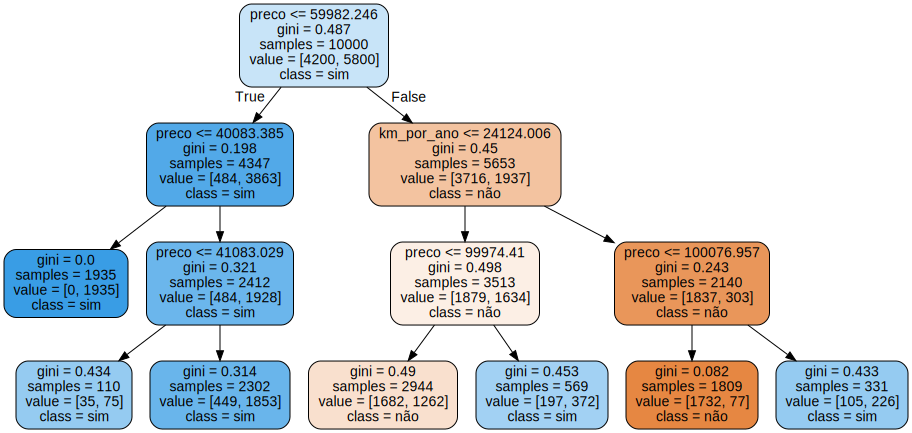

In [0]:
features = x_ordenado.columns

dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, class_names=["não","sim"], feature_names = features)
graph = graphviz.Source(dot_data)
graph

## Customizando o espaço de hiper parâmetros

In [0]:
from scipy.stats import randint

In [0]:
espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter = 16, cv = KFold(n_splits = 5, shuffle=True), random_state=SEED)
busca.fit(x_ordenado, y_ordenado)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='d...
                   pa

In [0]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013965,0.000565,0.001331,0.000172,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7785,0.7875,0.7735,0.8020,0.7940,0.7871,0.010283,1
1,0.016927,0.000558,0.001386,0.000072,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7660,0.7835,0.7675,0.7810,0.7900,0.7776,0.009346,12
2,0.016029,0.000531,0.001511,0.000148,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7710,0.7885,0.7660,0.7930,0.7875,0.7812,0.010652,6
3,0.020122,0.000855,0.001554,0.000066,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7635,0.7745,0.7590,0.7790,0.7670,0.7686,0.007262,15
4,0.015560,0.000321,0.001402,0.000093,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7710,0.7885,0.7660,0.7925,0.7875,0.7811,0.010542,7


In [0]:
scores = cross_val_score(busca, x_ordenado, y_ordenado, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Acurácia média 78.66
Intervalo [77.22, 80.10]


In [0]:
melhor = busca.best_estimator_

print(f"Melhor estimador {melhor}")

Melhor estimador DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [0]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.021) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.017) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +-(0.017) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.782 +-(0.022) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.781 +-(0.019) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.781 +-(0.021) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.781 +-(0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.781 +-(0.019) {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 104, 'min_samples_split': 88}
0.781 +-(0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.017) {'criterion': 'gini', 'max_depth':

## Uma exploração mais a fundo de forma aleatória

In [0]:
from scipy.stats import randint

In [0]:
espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter = 64, cv = KFold(n_splits = 5, shuffle=True), random_state = SEED)

busca.fit(x_ordenado, y_ordenado)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='d...
                   pa

In [0]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.021) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.017) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +-(0.017) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.782 +-(0.022) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.781 +-(0.019) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.781 +-(0.021) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.781 +-(0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.781 +-(0.019) {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 104, 'min_samples_split': 88}
0.781 +-(0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.017) {'criterion': 'gini', 'max_depth':

In [0]:
scores = cross_val_score(busca, x_ordenado, y_ordenado, cv=KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Acurácia média 78.71
Intervalo [78.22, 79.20]


In [0]:
melhor = busca.best_estimator_

print(f"Melhor estimador {melhor}")

Melhor estimador DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=53, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


## Comparação GridSearchCV vs RandomizedSearch

In [0]:
from sklearn.ensemble import RandomForestClassifier
import time

GridSearchCV

In [0]:
espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tempo_inicial = time.time()

busca = GridSearchCV(RandomForestClassifier(), espaco_de_parametros, cv=KFold(n_splits = 5, shuffle=True))
busca.fit(x_ordenado, y_ordenado)

tempo_final = time.time()
tempo_passado = tempo_final - tempo_inicial

print(f"Tempo {tempo_passado} segundos")

Tempo 201.2441394329071 segundos


In [0]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036196,0.002344,0.003336,0.000232,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7630,0.7690,0.7510,0.7820,0.7850,0.7700,0.012490,101
1,0.333653,0.007753,0.019361,0.000414,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7680,0.7850,0.7615,0.7805,0.7805,0.7751,0.008851,39
2,0.034471,0.001050,0.003229,0.000093,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7495,0.7815,0.7540,0.7610,0.7525,0.7597,0.011535,137
3,0.325808,0.004238,0.019045,0.000190,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7680,0.7850,0.7615,0.7800,0.7565,0.7702,0.010801,98
4,0.034645,0.001053,0.003256,0.000041,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7675,0.7340,0.7480,0.7745,0.7810,0.7610,0.017450,135


In [0]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.780 +-(0.026) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 32, 'n_estimators': 10}
0.778 +-(0.013) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 32, 'n_estimators': 10}
0.778 +-(0.015) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.016) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 32, 'n_estimators': 10}


In [0]:
tempo_inicial = time.time()

scores = cross_val_score(busca, x_ordenado, y_ordenado, cv = KFold(n_splits=5, shuffle=True))

tempo_final = time.time()
tempo_passado = tempo_final - tempo_inicial

print(f"Tempo {tempo_passado} segundos")

imprime_score(scores)

Tempo 838.9605116844177 segundos
Acurácia média 78.18
Intervalo [75.19, 81.17]


In [0]:
melhor = busca.best_estimator_

print(f"Melhor estimador {melhor}")

Melhor estimador RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=128,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


RandomizedSearchCV

In [0]:
espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tempo_inicial = time.time()

busca = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, n_iter = 20, cv=KFold(n_splits = 5, shuffle=True))
busca.fit(x_ordenado, y_ordenado)

tempo_final = time.time()
tempo_passado = tempo_final - tempo_inicial

print(f"Tempo {tempo_passado} segundos")

Tempo 27.10771107673645 segundos


In [0]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.398915,0.008472,0.022582,0.000308,100,128,128,5,gini,True,"{'n_estimators': 100, 'min_samples_split': 128...",0.7705,0.7740,0.7710,0.7855,0.7770,0.7756,0.005472,4
1,0.389211,0.006576,0.019565,0.000178,100,128,64,3,gini,False,"{'n_estimators': 100, 'min_samples_split': 128...",0.7465,0.7690,0.7715,0.7825,0.7770,0.7693,0.012315,17
2,0.045693,0.001957,0.003271,0.000091,10,64,64,3,entropy,True,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7490,0.7720,0.7635,0.7730,0.7715,0.7658,0.009059,19
3,0.332012,0.015051,0.019552,0.000386,100,64,128,3,gini,True,"{'n_estimators': 100, 'min_samples_split': 64,...",0.7700,0.7725,0.7720,0.7825,0.7765,0.7747,0.004434,10
4,0.567945,0.006983,0.022076,0.000118,100,64,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 64,...",0.7700,0.7720,0.7715,0.7825,0.7795,0.7751,0.004954,6


In [0]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.779 +-(0.010) {'n_estimators': 10, 'min_samples_split': 128, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.778 +-(0.007) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.777 +-(0.009) {'n_estimators': 100, 'min_samples_split': 128, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.011) {'n_estimators': 100, 'min_samples_split': 128, 'min_samples_leaf': 128, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}
0.775 +-(0.010) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [0]:
tempo_inicial = time.time()

scores = cross_val_score(busca, x_ordenado, y_ordenado, cv = KFold(n_splits=5, shuffle=True))

tempo_final = time.time()
tempo_passado = tempo_final - tempo_inicial

print(f"Tempo {tempo_passado} segundos")

imprime_score(scores)

Tempo 125.06551361083984 segundos
Acurácia média 76.94
Intervalo [75.30, 78.58]


In [0]:
melhor = busca.best_estimator_

print(f"Melhor estimador {melhor}")

Melhor estimador RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=64, min_samples_split=128,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


O que ocorre ao alterar os parametros?

In [0]:
espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tempo_inicial = time.time()

busca = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, n_iter = 80, cv=KFold(n_splits = 5, shuffle=True))
busca.fit(x_ordenado, y_ordenado)

tempo_final = time.time()
tempo_passado = tempo_final - tempo_inicial

print(f"Tempo {tempo_passado} segundos")

imprime_score(scores)

Tempo 98.44103336334229 segundos
Acurácia média 76.94
Intervalo [75.30, 78.58]


In [0]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.145641,0.007066,0.008316,0.000153,False,gini,3,102,42,37,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7825,0.7565,0.7610,0.7795,0.7855,0.7730,0.011874,55
1,0.261180,0.006060,0.014193,0.000275,False,gini,3,120,98,69,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7795,0.7705,0.7600,0.7790,0.7805,0.7739,0.007819,41
2,0.205657,0.004782,0.010300,0.000147,True,entropy,3,72,37,49,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7850,0.7660,0.7600,0.7745,0.7805,0.7732,0.009168,52
3,0.044944,0.001265,0.003866,0.000088,True,gini,3,58,35,13,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7845,0.7705,0.7615,0.7415,0.7505,0.7617,0.015039,78
4,0.165112,0.002090,0.009910,0.000110,True,gini,5,42,109,40,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7810,0.7720,0.7600,0.7770,0.7865,0.7753,0.009009,17


In [0]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.778 +-(0.019) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 90, 'min_samples_split': 121, 'n_estimators': 50}
0.778 +-(0.020) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 104, 'min_samples_split': 104, 'n_estimators': 25}
0.778 +-(0.014) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 48, 'n_estimators': 15}
0.777 +-(0.019) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 66, 'min_samples_split': 49, 'n_estimators': 34}
0.777 +-(0.018) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 35, 'min_samples_split': 123, 'n_estimators': 48}


# Quando devo ou não usar cross validation

0.6 para treino
</br>
0.2 para realizar os testes
</br>
0.2 validacao do modelo

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_ordenado, 
                                                                            y_ordenado,
                                                                            test_size=0.2, 
                                                                            shuffle=True, 
                                                                            stratify=y_ordenado)

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25)

tempo_inicial = time.time()

busca = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, n_iter = 5, cv=split)
busca.fit(x_treino_teste, y_treino_teste)

tempo_final = time.time()

tempo_que_passou = tempo_final - tempo_inicial

print(f"Tempo {tempo_que_passou} segundos")

Tempo 1.1846070289611816 segundos


In [0]:
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.119992,0.0,0.008869,0.0,True,gini,5,54,56,31,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7680,0.7680,0.0,3
1,0.269325,0.0,0.012658,0.0,False,entropy,4,102,75,55,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7665,0.7665,0.0,5
2,0.479534,0.0,0.020249,0.0,False,entropy,5,84,34,86,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7685,0.7685,0.0,2
3,0.088068,0.0,0.007107,0.0,True,gini,5,107,55,25,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7695,0.7695,0.0,1
4,0.058894,0.0,0.003612,0.0,False,entropy,4,107,49,10,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7670,0.7670,0.0,4


In [0]:
tempo_inicial = time.time()

scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)

tempo_final = time.time()
tempo_passado = tempo_final - tempo_inicial

print(f"Tempo {tempo_passado} segundos")

Tempo 0.6457638740539551 segundos


In [0]:
scores

array([0.732])